In [1]:
from fitparse import FitFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from datetime import time
import glob
import requests
from json import JSONDecodeError
import folium
import math
import statsmodels.formula.api as sm
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
df = pd.read_csv('rides.csv')
df.head()

,station_id,date,station_lat,station_long,hod,rides_began,rides_ended,excess_rides,month,dow,altitude,distance_to_transit,wind_speed,precipitation,snow,snow_depth,max_temp,min_temp
0,72.0,2017-01-01,40.767272,-73.993929,2,1,1,0,1,6,6.0,0.990991,2.5,0.0,0.0,0.0,8.9,4.4
1,72.0,2017-01-01,40.767272,-73.993929,8,2,2,0,1,6,6.0,0.990991,2.5,0.0,0.0,0.0,8.9,4.4
2,72.0,2017-01-01,40.767272,-73.993929,9,1,1,0,1,6,6.0,0.990991,2.5,0.0,0.0,0.0,8.9,4.4
3,72.0,2017-01-01,40.767272,-73.993929,12,5,3,-2,1,6,6.0,0.990991,2.5,0.0,0.0,0.0,8.9,4.4
4,72.0,2017-01-01,40.767272,-73.993929,13,6,1,-5,1,6,6.0,0.990991,2.5,0.0,0.0,0.0,8.9,4.4


In [2]:
df['excess_rides'].max()

146

# Regression Analysis

So far we have shown a few things.  First of all, my intial regression with all variables in for the first two years is not very effective at prediction.  A large reason for this is likely outliers and insufficient variation.  The dependent variable is heavily biased towards a small number of rides with large outliers.  This reduces the predictive power because so many observations have rides between 0 and 5 rides.

The next model we aggregate to month, dow, hod so 1 observation would be a given hour, for a given dow, in a given month.  Rides for 9AM Tuesday in April are all aggregated to one observation.  This helps with the predictive power by increasing the variation but is weakened because the observations are not tied to a specific date we must drop all weather variables.

Interestingly, aggregating to the day to increase weather does not give as much predictive power as the previous model with a lower $R^2$ value.

## Basic Model
This uses the data as it is brought in with all variables to try and predict rides.  We can see it is not that effective of a prediction tool which is likely because of the distribution of the number of rides.

In [3]:
model_1 = sm.ols(formula='rides_began ~  altitude + distance_to_transit + wind_speed + precipitation  + snow + snow_depth + max_temp + np.power(distance_to_transit, 2)+ np.power(distance_to_transit, 3) + np.power(max_temp, 2) + np.power(max_temp, 3) + np.power(max_temp, 4) + np.power(wind_speed, 2) + np.power(precipitation, 2) + np.power(precipitation, 3) + C(dow) + C(month) + C(hod)',
                          data=df).fit()
print(model_1.summary())


                            OLS Regression Results                            
Dep. Variable:            rides_began   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                 1.818e+04
Date:                Fri, 06 Nov 2020   Prob (F-statistic):               0.00
Time:                        10:43:23   Log-Likelihood:            -2.5261e+07
No. Observations:             7619215   AIC:                         5.052e+07
Df Residuals:                 7619159   BIC:                         5.052e+07
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [4]:
model_2 = sm.ols(formula='rides_ended ~  altitude + distance_to_transit + wind_speed + precipitation  + snow + snow_depth + max_temp + np.power(distance_to_transit, 2)+ np.power(distance_to_transit, 3) + np.power(max_temp, 2) + np.power(max_temp, 3) + np.power(max_temp, 4) + np.power(wind_speed, 2) + np.power(precipitation, 2) + np.power(precipitation, 3) + C(dow) + C(month) + C(hod)',
                          data=df).fit()
print(model_2.summary())


                            OLS Regression Results                            
Dep. Variable:            rides_ended   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                 1.796e+04
Date:                Fri, 06 Nov 2020   Prob (F-statistic):               0.00
Time:                        10:49:04   Log-Likelihood:            -2.5206e+07
No. Observations:             7619215   AIC:                         5.041e+07
Df Residuals:                 7619159   BIC:                         5.041e+07
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [5]:
model_3 = sm.ols(formula='excess_rides ~  altitude + distance_to_transit + wind_speed + precipitation  + snow + snow_depth + max_temp + min_temp + np.power(distance_to_transit, 2)+ np.power(distance_to_transit, 3) + np.power(max_temp, 2) + np.power(max_temp, 3) + np.power(max_temp, 4) + np.power(wind_speed, 2) + np.power(precipitation, 2) + np.power(precipitation, 3) + C(dow) + C(month) + C(hod)',
                          data=df).fit()
print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:           excess_rides   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     577.2
Date:                Fri, 06 Nov 2020   Prob (F-statistic):               0.00
Time:                        10:54:44   Log-Likelihood:            -2.3771e+07
No. Observations:             7619215   AIC:                         4.754e+07
Df Residuals:                 7619158   BIC:                         4.754e+07
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

## Aggregate to full day

This aggregates to the full day it is not ideal because we want to predict hourly data but it allows us to aggregate to a higher level to help with variation and keep 

In [6]:
## Group by to sum the number of rides to the day
began_group = df.groupby(['station_id','date','altitude','distance_to_transit'],as_index = False).rides_began.sum()
end_group = df.groupby(['station_id','date','altitude','distance_to_transit'],as_index = False).rides_ended.sum()
excess_group = df.groupby(['station_id','date','altitude','distance_to_transit'],as_index = False).excess_rides.sum()

## Get all the weather data for each day
date = df[['date','month','dow','wind_speed','precipitation','snow','snow_depth','max_temp','min_temp']].drop_duplicates()

## Join the weather data to the grouped datasets
began_group = began_group.join(date.set_index('date'),on = 'date')
end_group = end_group.join(date.set_index('date'),on = 'date')
excess_group = excess_group.join(date.set_index('date'),on = 'date')

In [7]:
model_4 = sm.ols(formula='rides_began ~  altitude + distance_to_transit + np.power(distance_to_transit , 3) + np.power(distance_to_transit , 2)  + wind_speed + precipitation  + snow + snow_depth + max_temp + min_temp + np.power(max_temp, 2) + np.power(wind_speed, 2) + np.power(precipitation, 2)  + C(dow) + C(month) ',
                         data=began_group).fit()
print(model_4.summary())

                            OLS Regression Results                            
Dep. Variable:            rides_began   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     3736.
Date:                Fri, 06 Nov 2020   Prob (F-statistic):               0.00
Time:                        10:55:23   Log-Likelihood:            -3.7046e+06
No. Observations:              648145   AIC:                         7.409e+06
Df Residuals:                  648114   BIC:                         7.410e+06
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [8]:
model_5 = sm.ols(formula='rides_ended ~  altitude + distance_to_transit + np.power(distance_to_transit , 3) + np.power(distance_to_transit , 2)  + wind_speed + precipitation  + snow + snow_depth + max_temp + min_temp + np.power(max_temp, 2) + np.power(wind_speed, 2) + np.power(precipitation, 2)  + C(dow) + C(month) ',
                         data=end_group).fit()
print(model_5.summary())

                            OLS Regression Results                            
Dep. Variable:            rides_ended   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     3616.
Date:                Fri, 06 Nov 2020   Prob (F-statistic):               0.00
Time:                        10:55:39   Log-Likelihood:            -3.7092e+06
No. Observations:              648145   AIC:                         7.418e+06
Df Residuals:                  648114   BIC:                         7.419e+06
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [9]:
model_6 = sm.ols(formula='excess_rides ~  altitude + distance_to_transit + np.power(distance_to_transit , 3) + np.power(distance_to_transit , 2)  + wind_speed + precipitation  + snow + snow_depth + max_temp + min_temp + np.power(max_temp, 2) + np.power(wind_speed, 2) + np.power(precipitation, 2)  + C(dow) + C(month) ',
                         data=excess_group).fit()
print(model_6.summary())

                            OLS Regression Results                            
Dep. Variable:           excess_rides   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     222.7
Date:                Fri, 06 Nov 2020   Prob (F-statistic):               0.00
Time:                        10:55:55   Log-Likelihood:            -2.4664e+06
No. Observations:              648145   AIC:                         4.933e+06
Df Residuals:                  648114   BIC:                         4.933e+06
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

# Residual Plots

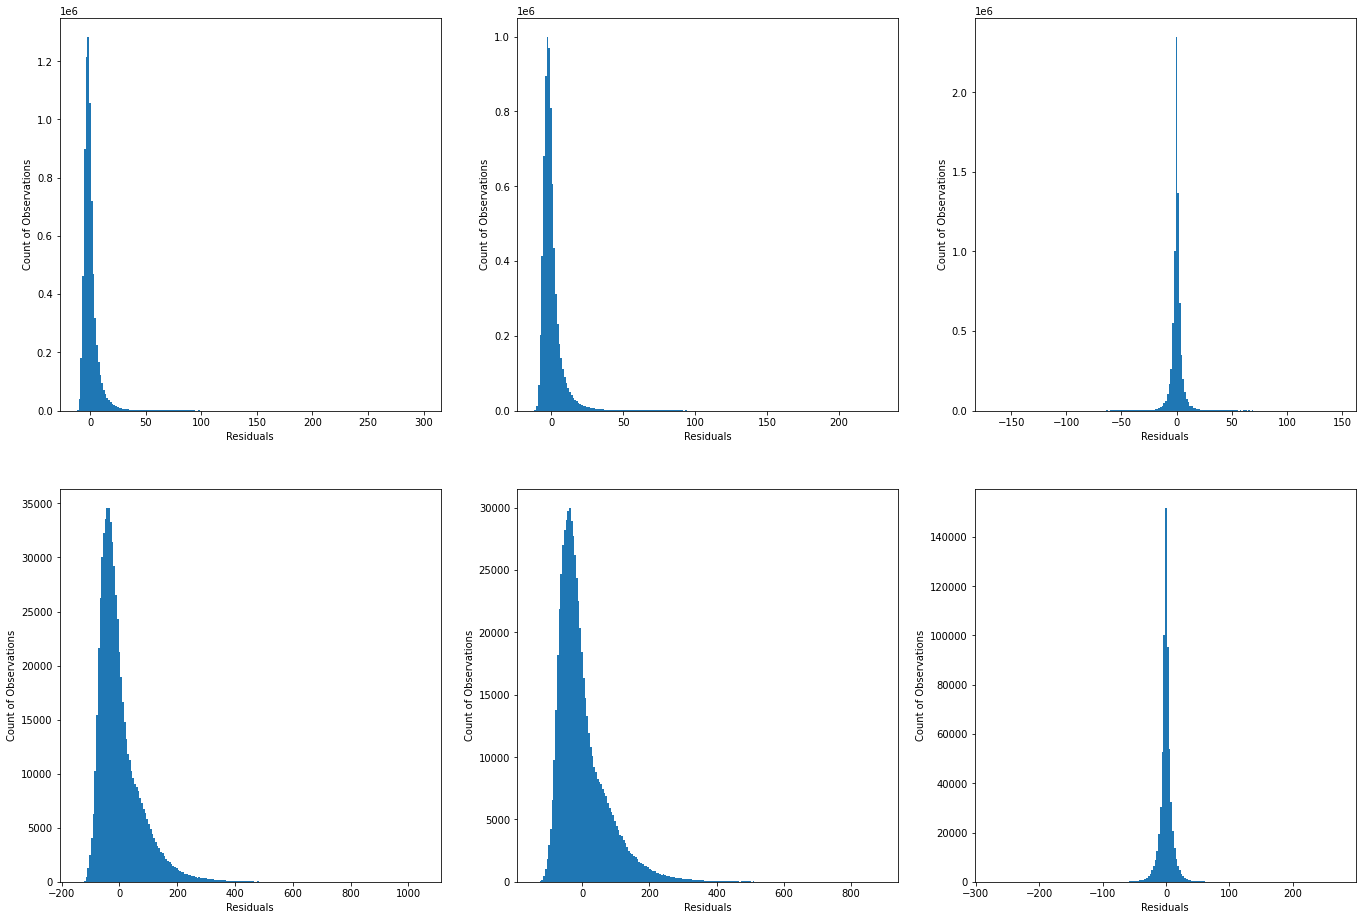

In [28]:
fig = plt.figure()
ax1 =  fig.add_subplot(231)
ax2 =  fig.add_subplot(232)
ax3 =  fig.add_subplot(233)
ax4 =  fig.add_subplot(234)
ax5 =  fig.add_subplot(235)
ax6 =  fig.add_subplot(236)

ax1.hist(model_1.resid,bins = 200)
ax1.set_xlabel('Residuals')
ax1.set_ylabel('Count of Observations')

ax2.hist(model_2.resid,bins = 200)
ax2.set_xlabel('Residuals')
ax2.set_ylabel('Count of Observations')

ax3.hist(model_3.resid,bins = 200)
ax3.set_xlabel('Residuals')
ax3.set_ylabel('Count of Observations')

ax4.hist(model_4.resid,bins = 200)
ax4.set_xlabel('Residuals')
ax4.set_ylabel('Count of Observations')

ax5.hist(model_5.resid,bins = 200)
ax5.set_xlabel('Residuals')
ax5.set_ylabel('Count of Observations')

ax6.hist(model_6.resid,bins = 200)
ax6.set_xlabel('Residuals')
ax6.set_ylabel('Count of Observations')

plt.subplots_adjust(left=0, bottom=0, right=3, top=3, wspace=0.2, hspace=0.2)
plt.show()

# VISUALIZATIONS

## Bar Graph of Rides broken down by year and month

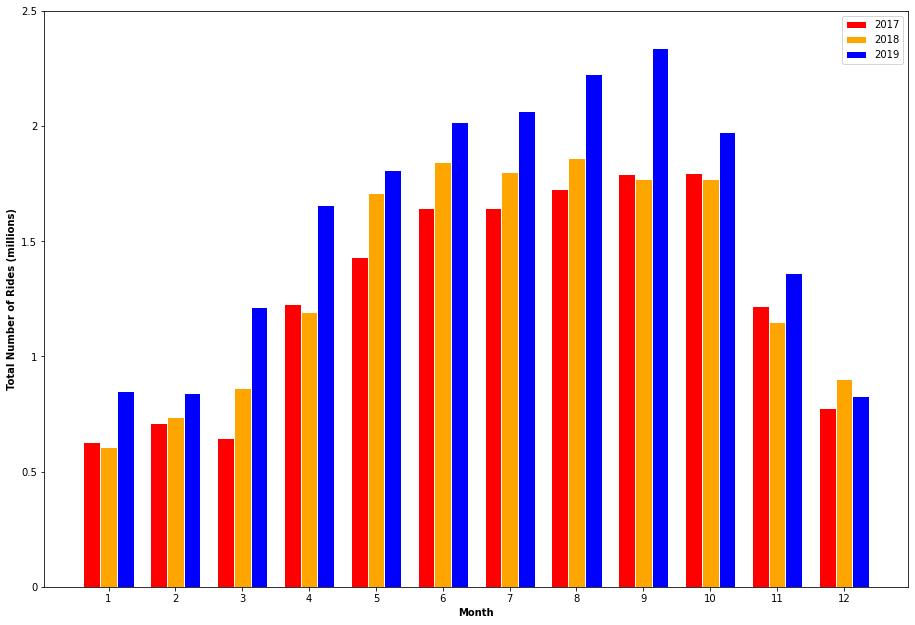

In [11]:
barWidth = 0.25
df['year'] = pd.to_datetime(df['date']).dt.year
growth = df.groupby(['year','month'],as_index = False).rides_began.sum()

bars1 = growth.loc[growth['year'] == 2017,'rides_began']
bars2 = growth.loc[growth['year'] == 2018,'rides_began']
bars3 = growth.loc[growth['year'] == 2019,'rides_began']


r1 = range(0,12)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, bars1, color='red', width=barWidth, edgecolor='white', label='2017')
plt.bar(r2, bars2, color='orange', width=barWidth, edgecolor='white', label='2018')
plt.bar(r3, bars3, color='blue', width=barWidth, edgecolor='white', label='2019')
 
# Add xticks on the middle of the group bars
plt.xlabel('Month', fontweight='bold')
plt.ylabel('Total Number of Rides (millions)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [1,2,3,4,5,6,7,8,9,10,11,12])
plt.yticks(range(0,2500001,500000),[0,0.5,1,1.5,2,2.5]) 
# Create legend & Show graphic
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0, hspace=0.2)
plt.legend()

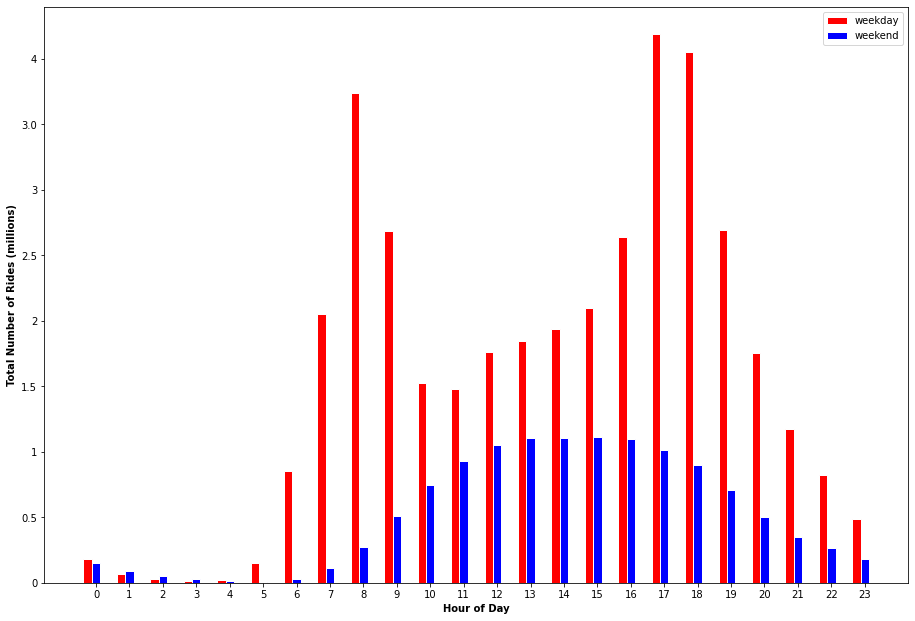

In [12]:
barWidth = 0.25

bars1 = df[df['dow'] < 5]
bars1 = bars1.groupby(['hod'],as_index = False).rides_began.sum()['rides_began']
bars2 = df[df['dow'] >= 5]
bars2 = bars2.groupby(['hod'],as_index = False).rides_began.sum()['rides_began']




r1 = range(0,24)
r2 = [x + barWidth for x in r1]


# Make the plot
plt.bar(r1, bars1, color='red', width=barWidth, edgecolor='white', label='weekday')
plt.bar(r2, bars2, color='blue', width=barWidth, edgecolor='white', label='weekend')

# Add xticks on the middle of the group bars
plt.xlabel('Hour of Day', fontweight='bold')
plt.ylabel('Total Number of Rides (millions)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], range(0,24))
plt.yticks(range(0,4000001,500000),[0,0.5,1,1.5,2,2.5,3,3.,4]) 
# Create legend & Show graphic
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0, hspace=0.2)
plt.legend()


# Weather Plots
## Max Temp

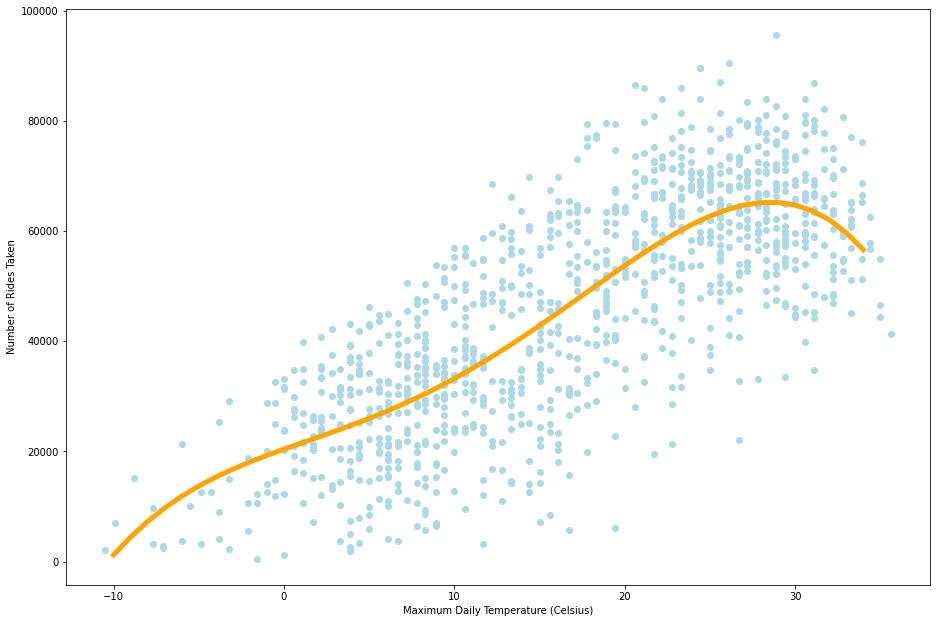

In [13]:
weather = df.groupby(['date','max_temp'],as_index = False).rides_began.sum()
x = np.array(weather['max_temp'])
y =np.array(weather['rides_began'])
m4, m3, m2 , m , b = np.polyfit(x, y, 4)
temp = np.arange(-10,35)
fitted = m * temp + m2 * (temp ** 2) + m3 * (temp ** 3)  + m4 * (temp ** 4)+ b
plt.scatter(weather['max_temp'],weather['rides_began'],color = 'lightblue')
plt.plot(temp,fitted,color = 'orange',linewidth = 5)
plt.xlabel('Maximum Daily Temperature (Celsius)')
plt.ylabel('Number of Rides Taken')
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0, hspace=0.2)
plt.show()

## Precipitation

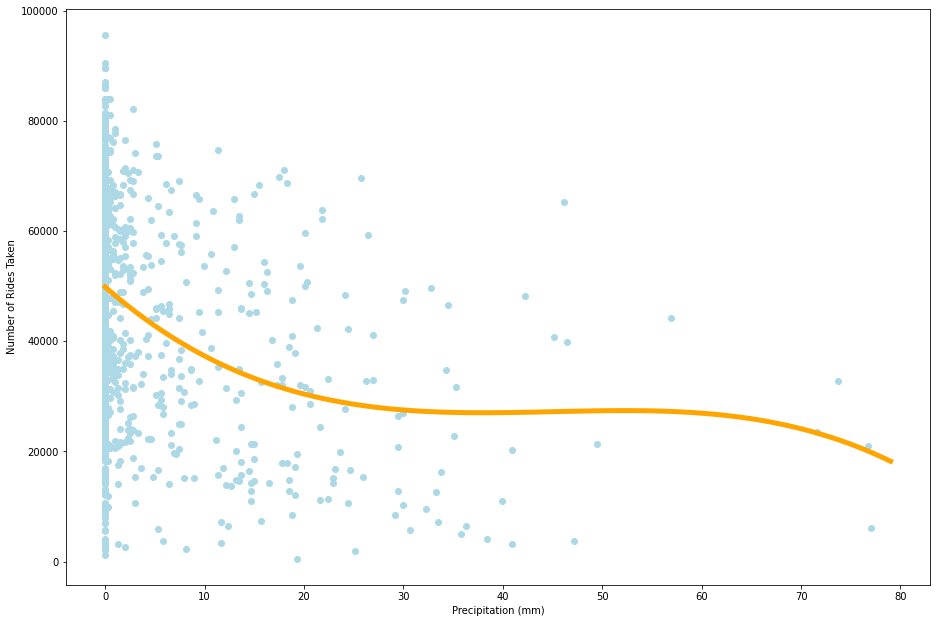

In [14]:
weather = df.groupby(['date','precipitation'],as_index = False).rides_began.sum()
x = np.array(weather['precipitation'])
y =np.array(weather['rides_began'])
m3 ,m2 , m , b = np.polyfit(x, y, 3)
temp = np.arange(0,80)
fitted = m * temp + m2 * (temp ** 2) + m3 * (temp ** 3) + b
plt.scatter(weather['precipitation'],weather['rides_began'],color = 'lightblue')
plt.plot(temp,fitted,color = 'orange',linewidth = 5)
plt.xlabel('Precipitation (mm)')
plt.ylabel('Number of Rides Taken')
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0, hspace=0.2)
plt.show()

## Windspeed

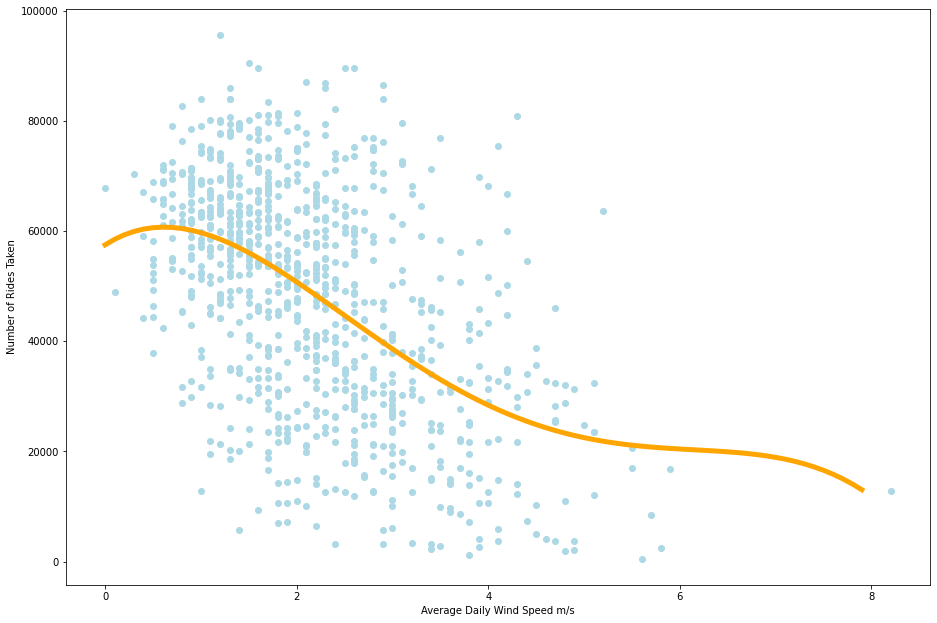

In [15]:
weather = df.groupby(['date','wind_speed'],as_index = False).rides_began.sum()
x = np.array(weather['wind_speed'])
y =np.array(weather['rides_began'])
m4, m3, m2 , m , b = np.polyfit(x, y, 4)
ws = np.arange(0,8,0.1)
fitted = m * ws + m2 * (ws ** 2) + m3 * (ws ** 3)  + m4 * (ws ** 4)+ b
plt.scatter(weather['wind_speed'],weather['rides_began'],color = 'lightblue')
plt.plot(ws,fitted,color = 'orange',linewidth = 5)
plt.xlabel('Average Daily Wind Speed m/s')
plt.ylabel('Number of Rides Taken')
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0, hspace=0.2)
plt.show()

## Distance to transit Plot

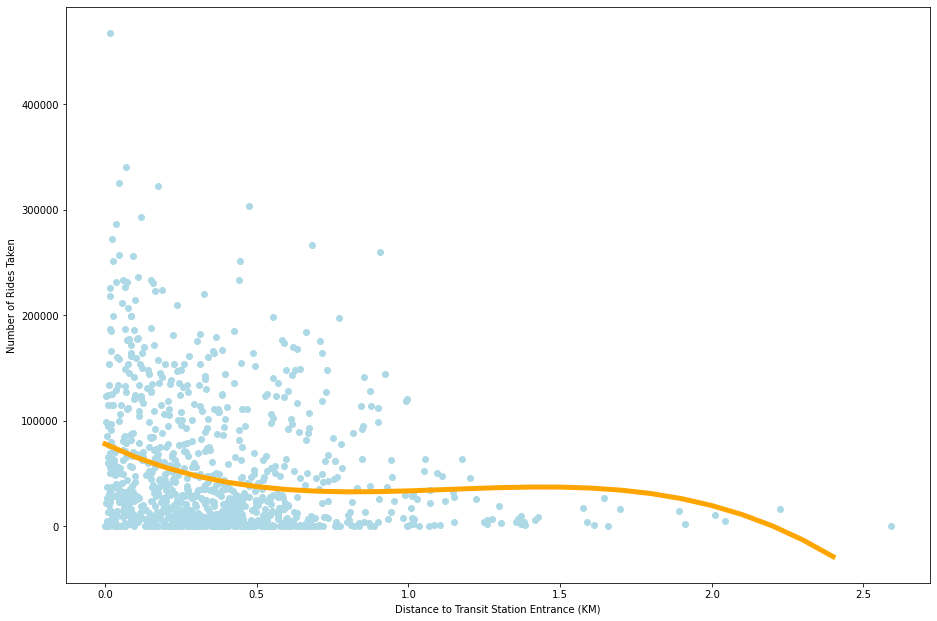

In [16]:
stations = df.groupby(['station_id','distance_to_transit'],as_index = False).rides_began.sum()
stations.sort_values(by=['distance_to_transit'])
x = np.array(stations['distance_to_transit'])
y =np.array(stations['rides_began'])
m3, m2 , m , b = np.polyfit(x, y, 3)
distance = np.arange(0,2.5,0.1)
fitted = m * distance + m2 * (distance ** 2) + m3 * (distance ** 3)  + b


plt.scatter(stations['distance_to_transit'],stations['rides_began'],color = 'lightblue')
plt.plot(distance,fitted,color = 'orange',linewidth = 5)
plt.xlabel('Distance to Transit Station Entrance (KM)')
plt.ylabel('Number of Rides Taken')
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0, hspace=0.2)

## Altitude Plot

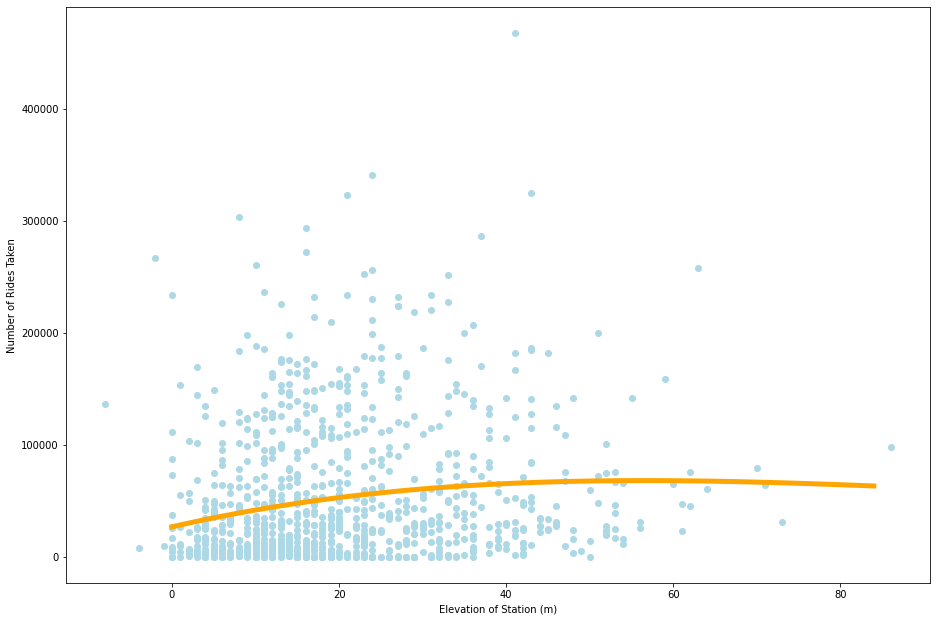

In [17]:
stations = df.groupby(['station_id','altitude'],as_index = False).rides_began.sum()
stations.sort_values(by=['altitude'])
x = np.array(stations['altitude'])
y =np.array(stations['rides_began'])
m3, m2 , m , b = np.polyfit(x, y, 3)
altitude = np.arange(0,85)
fitted = m * altitude + m2 * (altitude ** 2) + m3 * (altitude ** 3)  + b


plt.scatter(stations['altitude'],stations['rides_began'],color = 'lightblue')
plt.plot(altitude,fitted,color = 'orange',linewidth = 5)
plt.xlabel('Elevation of Station (m)')
plt.ylabel('Number of Rides Taken')
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0, hspace=0.2)

## Subplots for rides began and ended

In [18]:
stations_began = df.groupby(['station_id','distance_to_transit','altitude'],as_index = False).rides_began.sum()
stations_ended = df.groupby(['station_id','distance_to_transit','altitude'],as_index = False).rides_ended.sum()
stations_excess = df.groupby(['station_id','distance_to_transit','altitude'],as_index = False).excess_rides.sum()

## Distance to transit plots

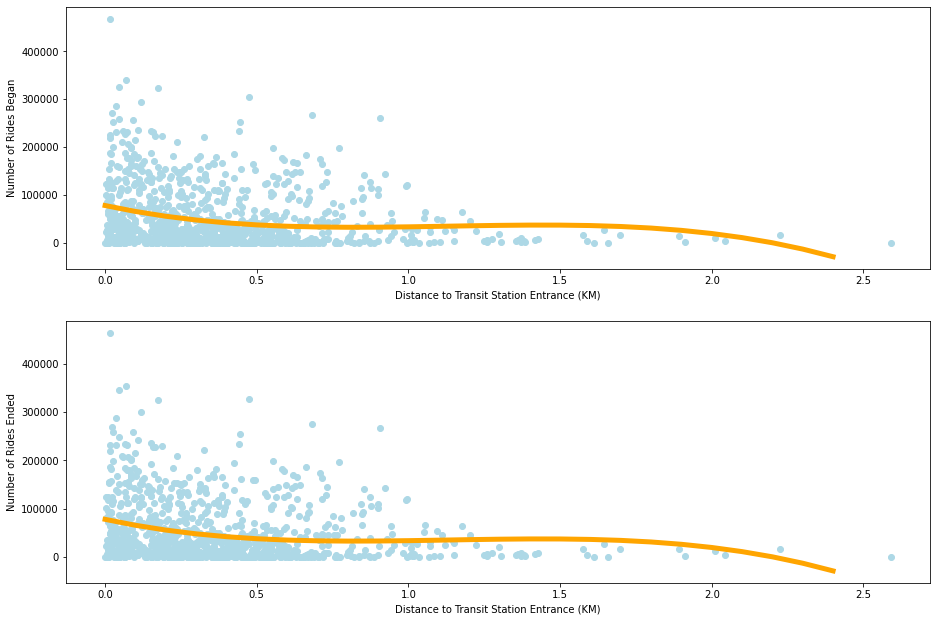

In [19]:
## Create the nonlinear trend lines
distance = np.arange(0,2.5,0.1)
x = np.array(stations_began['distance_to_transit'])

y = np.array(stations_began['rides_began'])
m3, m2 , m , b = np.polyfit(x, y, 3)
fitted_began = m * distance + m2 * (distance ** 2) + m3 * (distance ** 3)  + b

y = np.array(stations_ended['rides_ended'])
m3, m2 , m , b = np.polyfit(x, y, 3)
fitted_ended = m * distance + m2 * (distance ** 2) + m3 * (distance ** 3)  + b

## Create the plots
fig = plt.figure()
ax1 =  fig.add_subplot(211)
ax2 =  fig.add_subplot(212)
ax1.scatter(x,stations_began['rides_began'],color = 'lightblue')
ax1.plot(distance,fitted_began,color = 'orange',linewidth = 5)
ax1.set_xlabel('Distance to Transit Station Entrance (KM)')
ax1.set_ylabel('Number of Rides Began')


ax2.scatter(x,stations_ended['rides_ended'],color = 'lightblue')
ax2.plot(distance,fitted_ended,color = 'orange',linewidth = 5)
ax2.set_xlabel('Distance to Transit Station Entrance (KM)')
ax2.set_ylabel('Number of Rides Ended')
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0, hspace=0.2)

## Altitude Plots

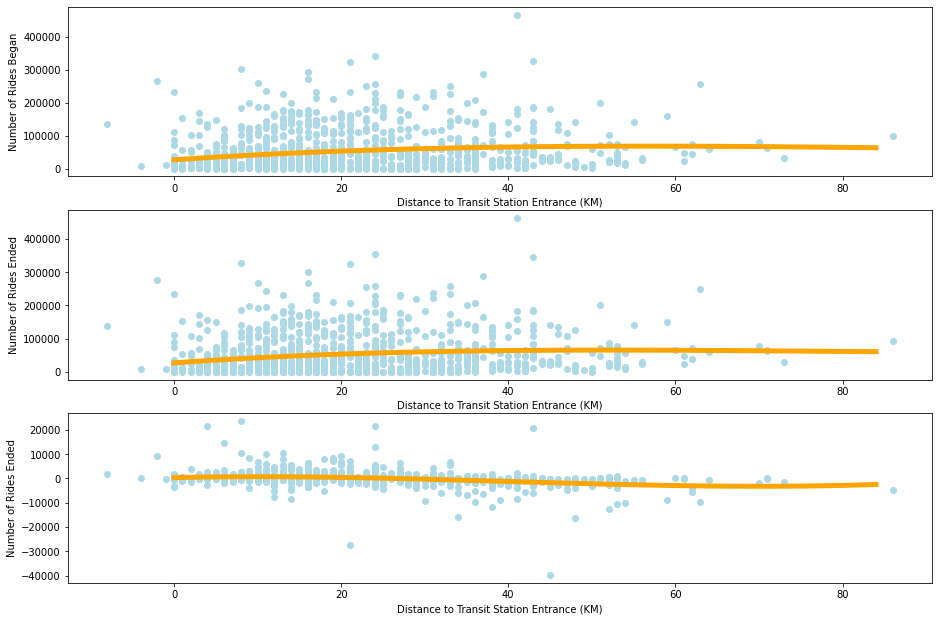

In [20]:
## Create the nonlinear trend lines
altitude = np.arange(0,85)
x = np.array(stations_began['altitude'])

y = np.array(stations_began['rides_began'])
m3, m2 , m , b = np.polyfit(x, y, 3)
fitted_began = m * altitude + m2 * (altitude ** 2) + m3 * (altitude ** 3)  + b

y = np.array(stations_ended['rides_ended'])
m3, m2 , m , b = np.polyfit(x, y, 3)
fitted_ended = m * altitude + m2 * (altitude ** 2) + m3 * (altitude ** 3)  + b

y = np.array(stations_excess['excess_rides'])
m3, m2 , m , b = np.polyfit(x, y, 3)
fitted_excess = m * altitude + m2 * (altitude ** 2) + m3 * (altitude ** 3)  + b

## Create the plots
fig = plt.figure()
ax1 =  fig.add_subplot(311)
ax2 =  fig.add_subplot(312)
ax3 =  fig.add_subplot(313)
ax1.scatter(x,stations_began['rides_began'],color = 'lightblue')
ax1.plot(altitude,fitted_began,color = 'orange',linewidth = 5)
ax1.set_xlabel('Distance to Transit Station Entrance (KM)')
ax1.set_ylabel('Number of Rides Began')


ax2.scatter(x,stations_ended['rides_ended'],color = 'lightblue')
ax2.plot(altitude,fitted_ended,color = 'orange',linewidth = 5)
ax2.set_xlabel('Distance to Transit Station Entrance (KM)')
ax2.set_ylabel('Number of Rides Ended')

ax3.scatter(x,stations_excess['excess_rides'],color = 'lightblue')
ax3.plot(altitude,fitted_excess,color = 'orange',linewidth = 5)
ax3.set_xlabel('Distance to Transit Station Entrance (KM)')
ax3.set_ylabel('Number of Rides Ended')
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0, hspace=0.2)

In [21]:
stations_excess[(stations_excess['excess_rides'] > 10000) | (stations_excess['excess_rides'] < -10000)]

,station_id,distance_to_transit,altitude,excess_rides
27,217.0,0.459843,6.0,14421
70,281.0,0.060226,21.0,-27561
84,304.0,0.012689,4.0,21781
103,324.0,0.010952,24.0,21440
148,377.0,0.036989,8.0,10581
160,391.0,0.018823,38.0,-11648
171,402.0,0.046999,43.0,20930
191,426.0,0.474595,8.0,23621
208,445.0,0.426440,11.0,10095
257,497.0,0.070485,24.0,12942


In [22]:
df[df['station_id'] == 217]

,station_id,date,station_lat,station_long,hod,rides_began,rides_ended,excess_rides,month,dow,altitude,distance_to_transit,wind_speed,precipitation,snow,snow_depth,max_temp,min_temp,year
362210,217.0,2017-01-01,40.702772,-73.993836,12,4,7,3,1,6,6.0,0.459843,2.5,0.0,0.0,0.0,8.9,4.4,2017
362211,217.0,2017-01-01,40.702772,-73.993836,13,1,13,12,1,6,6.0,0.459843,2.5,0.0,0.0,0.0,8.9,4.4,2017
362212,217.0,2017-01-01,40.702772,-73.993836,14,14,2,-12,1,6,6.0,0.459843,2.5,0.0,0.0,0.0,8.9,4.4,2017
362213,217.0,2017-01-01,40.702772,-73.993836,15,6,11,5,1,6,6.0,0.459843,2.5,0.0,0.0,0.0,8.9,4.4,2017
362214,217.0,2017-01-01,40.702772,-73.993836,16,3,6,3,1,6,6.0,0.459843,2.5,0.0,0.0,0.0,8.9,4.4,2017
362215,217.0,2017-01-01,40.702772,-73.993836,17,1,2,1,1,6,6.0,0.459843,2.5,0.0,0.0,0.0,8.9,4.4,2017
362216,217.0,2017-01-01,40.702772,-73.993836,18,2,3,1,1,6,6.0,0.459843,2.5,0.0,0.0,0.0,8.9,4.4,2017
362217,217.0,2017-01-01,40.702772,-73.993836,19,2,1,-1,1,6,6.0,0.459843,2.5,0.0,0.0,0.0,8.9,4.4,2017
362218,217.0,2017-01-02,40.702772,-73.993836,7,2,2,0,1,0,6.0,0.459843,4.1,5.3,0.0,0.0,5.0,2.8,2017
362219,217.0,2017-01-03,40.702772,-73.993836,8,2,3,1,1,1,6.0,0.459843,4.8,14.7,0.0,0.0,6.1,3.9,2017


# Rides by Hour of Day

In [23]:
weekday = df[df['dow'] < 5]
weekend = df[df['dow'] >= 5]

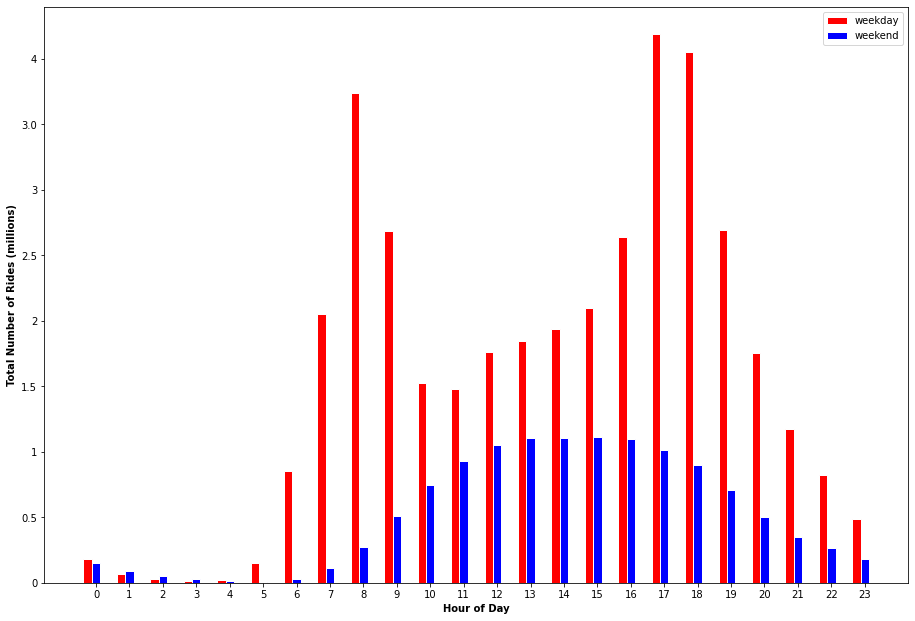

In [24]:
barWidth = 0.25

bars1 = weekday.groupby(['hod'],as_index = False).rides_began.sum()['rides_began']
bars2 = weekend.groupby(['hod'],as_index = False).rides_began.sum()['rides_began']


r1 = range(0,24)
r2 = [x + barWidth for x in r1]


# Make the plot
plt.bar(r1, bars1, color='red', width=barWidth, edgecolor='white', label='weekday')
plt.bar(r2, bars2, color='blue', width=barWidth, edgecolor='white', label='weekend')

# Add xticks on the middle of the group bars
plt.xlabel('Hour of Day', fontweight='bold')
plt.ylabel('Total Number of Rides (millions)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], range(0,24))
plt.yticks(range(0,4000001,500000),[0,0.5,1,1.5,2,2.5,3,3.,4]) 
# Create legend & Show graphic
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0, hspace=0.2)
plt.legend()


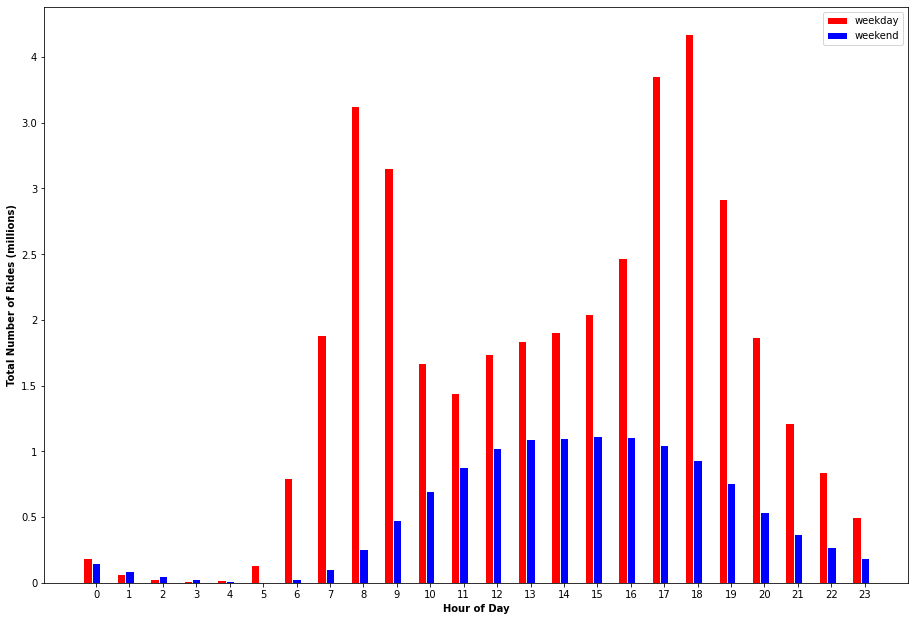

In [25]:
barWidth = 0.25

bars1 = weekday.groupby(['hod'],as_index = False).rides_ended.sum()['rides_ended']
bars2 = weekend.groupby(['hod'],as_index = False).rides_ended.sum()['rides_ended']


r1 = range(0,24)
r2 = [x + barWidth for x in r1]


# Make the plot
plt.bar(r1, bars1, color='red', width=barWidth, edgecolor='white', label='weekday')
plt.bar(r2, bars2, color='blue', width=barWidth, edgecolor='white', label='weekend')

# Add xticks on the middle of the group bars
plt.xlabel('Hour of Day', fontweight='bold')
plt.ylabel('Total Number of Rides (millions)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], range(0,24))
plt.yticks(range(0,4000001,500000),[0,0.5,1,1.5,2,2.5,3,3.,4]) 
# Create legend & Show graphic
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0, hspace=0.2)
plt.legend()


# MAPS
Make map of stations that exist.

In [26]:
data_2017 = df.loc[df['date'] < '2018-01-01',['station_id','station_lat','station_long']].drop_duplicates()
nyc = df.loc[df['date'] >= '2019-01-01',['station_id','station_lat','station_long']].drop_duplicates(subset='station_id', keep='first').reset_index()

m = folium.Map(location=[40.7812, -73.9665], zoom_start=12)
for i in nyc.index:
    folium.Marker([nyc.loc[i,'station_lat'], nyc.loc[i,'station_long']],popup = nyc.loc[i,'station_id']).add_to(m)

m